# Packages

In [1]:
import pandas as pd
import numpy as np

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

import miceforest as mf
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    roc_curve, roc_auc_score, classification_report,
    precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay
)

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import xgboost as xgb
import shap

from MLstatkit import Delong_test

d:\Working_project\Chronic_endometritis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Display settings

In [3]:
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid", palette="deep", color_codes=True)
sns.set_palette("Blues_d")

# Load Data

In [4]:
df = pd.read_csv(r'./data/raw/raw_data_CE_total.csv')
print(df.shape)
print(df.columns)

(108, 31)
Index(['CE', 'age', 'VAT', 'menstr_cycle_duration', 'endometr_thick',
       'uterine_fibroids', 'PBAC', 'heavy_menstr_bleeding_day', 'TSH', 'PRL',
       'LH', 'FSH', 'SHBG', '17OH', 'AMH', 'T', 'CRP', 'LEP', 'ADIPOQ', 'IL1',
       'IL6', 'IL8', 'IL10', 'TNFa', 'IFN', 'E2', 'endometrial_polyp',
       'spontaneous_abortions', 'extrauterine_pregnancy', 'c_section',
       'missed_abortion'],
      dtype='object')


# Define Features

In [5]:
target = 'CE'

cat = [
    'uterine_fibroids',
    'endometrial_polyp',
    'spontaneous_abortions',
    'extrauterine_pregnancy', 
    'c_section', 
    'missed_abortion'
]

num = [
    'age', 'VAT', 'menstr_cycle_duration', 'endometr_thick',
    'PBAC', 'heavy_menstr_bleeding_day', 'TSH', 'PRL',
    'LH', 'FSH', 'SHBG', '17OH', 'AMH', 'T', 'CRP', 'LEP', 'ADIPOQ', 'IL1',
    'IL6', 'IL8', 'IL10', 'TNFa', 'IFN', 'E2'
]

# Quick EDA

In [6]:
print("Target distribution:")
print(df[target].value_counts())

Target distribution:
CE
0    64
1    44
Name: count, dtype: int64


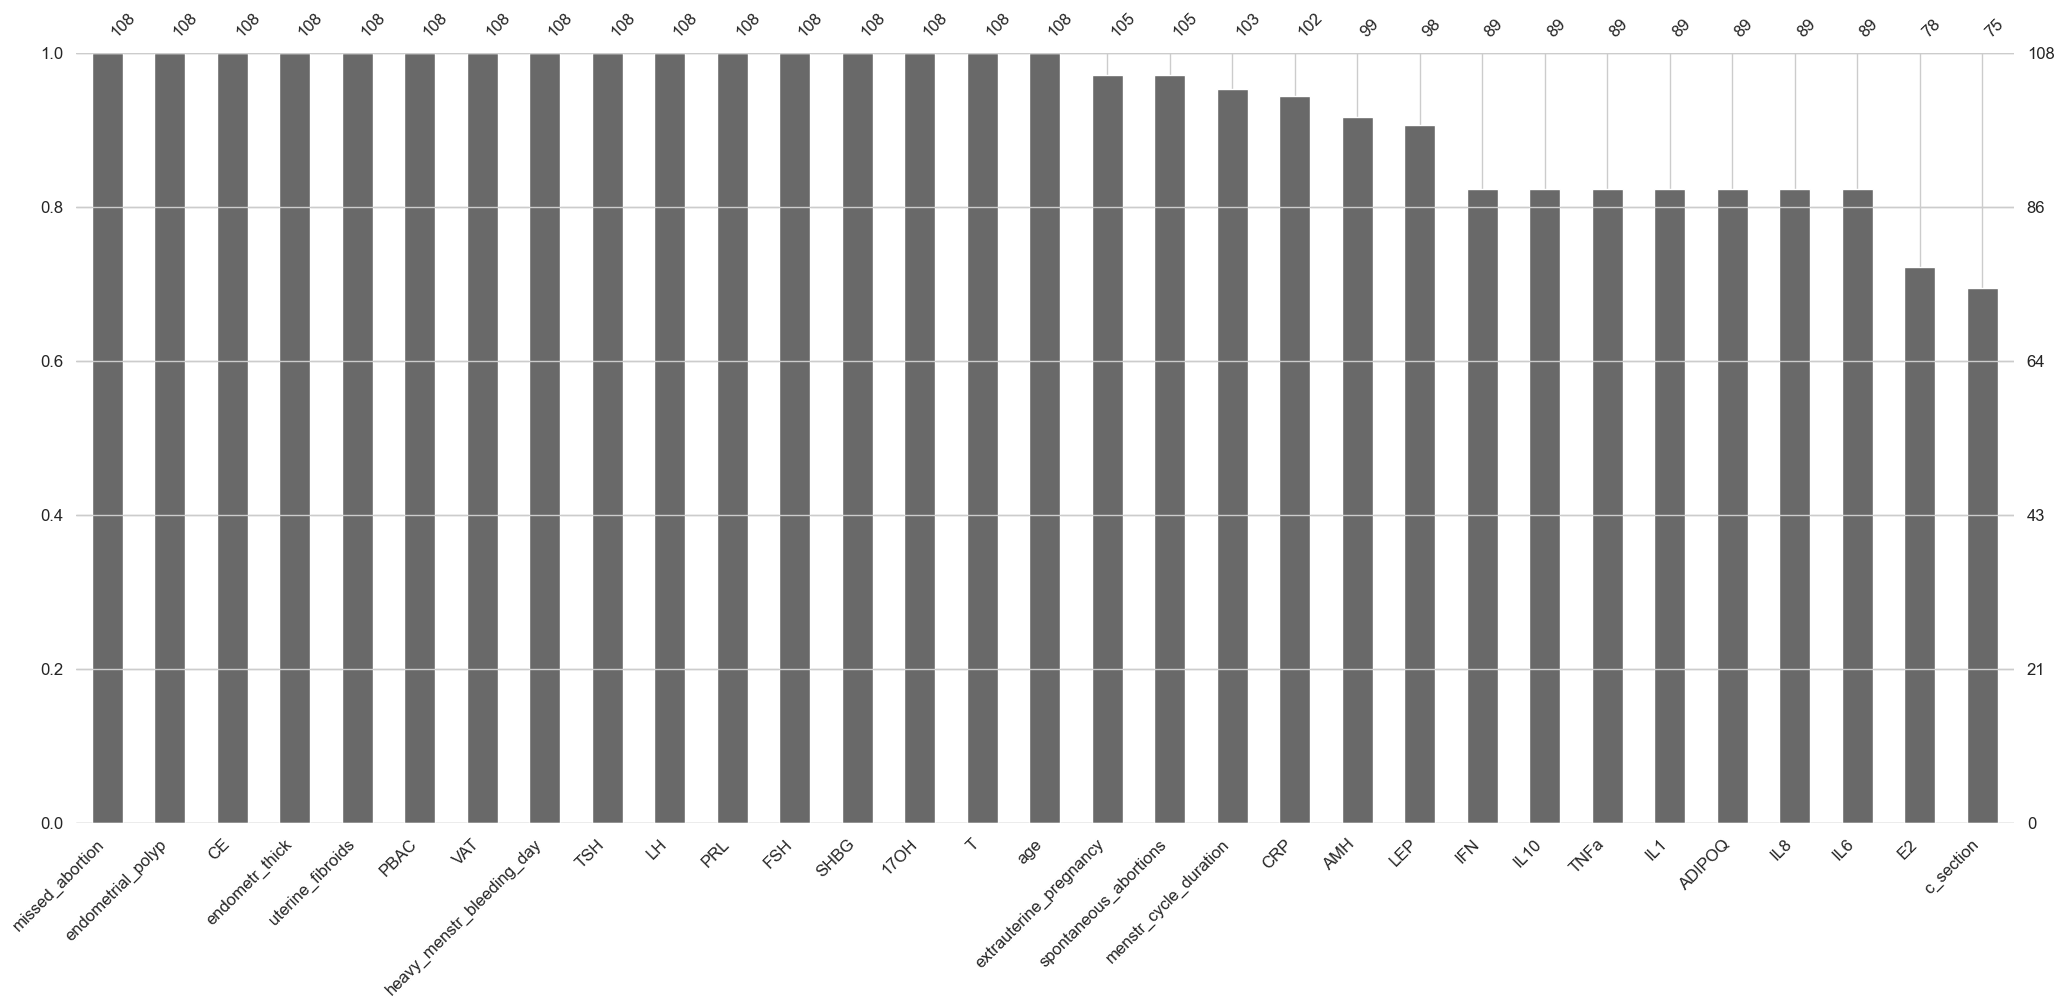

In [7]:
# Missing values overview
msno.bar(df, sort='descending', fontsize=12)
plt.show()

# Outlier handling

17OH                             Axes(0.125,0.77;0.133621x0.11)
ADIPOQ                        Axes(0.285345,0.77;0.133621x0.11)
AMH                            Axes(0.44569,0.77;0.133621x0.11)
CRP                           Axes(0.606034,0.77;0.133621x0.11)
E2                            Axes(0.766379,0.77;0.133621x0.11)
FSH                             Axes(0.125,0.638;0.133621x0.11)
IFN                          Axes(0.285345,0.638;0.133621x0.11)
IL1                           Axes(0.44569,0.638;0.133621x0.11)
IL10                         Axes(0.606034,0.638;0.133621x0.11)
IL6                          Axes(0.766379,0.638;0.133621x0.11)
IL8                             Axes(0.125,0.506;0.133621x0.11)
LEP                          Axes(0.285345,0.506;0.133621x0.11)
LH                            Axes(0.44569,0.506;0.133621x0.11)
PBAC                         Axes(0.606034,0.506;0.133621x0.11)
PRL                          Axes(0.766379,0.506;0.133621x0.11)
SHBG                            Axes(0.1

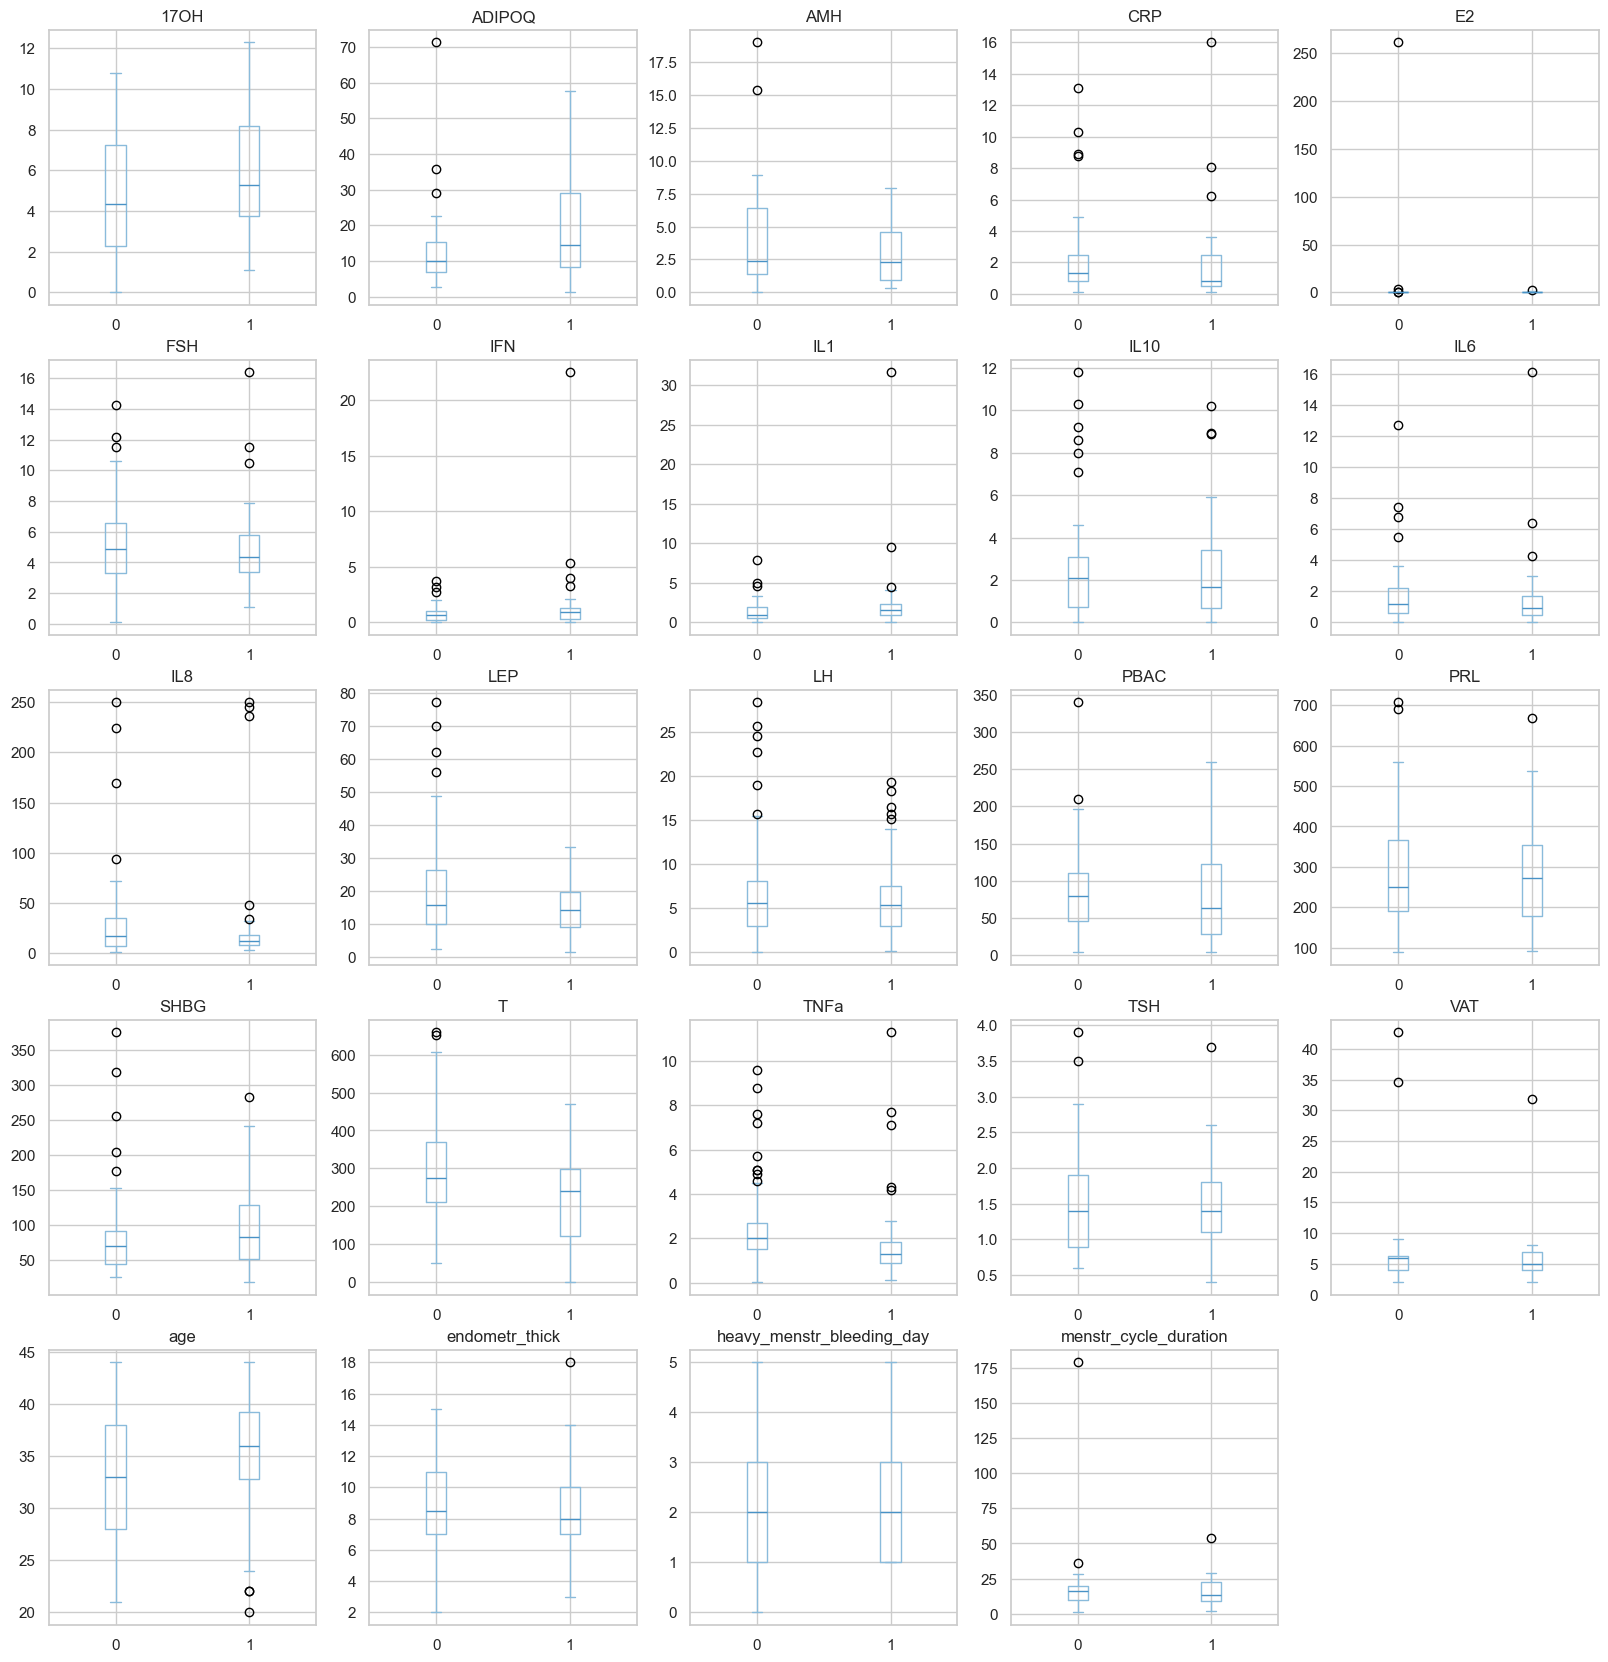

In [8]:
df[[target]+num].plot.box(subplots=True, figsize=(20,25), layout=(6, 5), by=target)

In [9]:
# Replace extreme values with NaN
df.loc[df[df['E2'] > 250].index, 'E2'] = None
df.loc[df[df['menstr_cycle_duration'] > 170].index, 'menstr_cycle_duration'] = None

array([[<Axes: title={'center': 'CE'}>,
        <Axes: title={'center': 'uterine_fibroids'}>,
        <Axes: title={'center': 'endometrial_polyp'}>,
        <Axes: title={'center': 'spontaneous_abortions'}>,
        <Axes: title={'center': 'extrauterine_pregnancy'}>],
       [<Axes: title={'center': 'c_section'}>,
        <Axes: title={'center': 'missed_abortion'}>, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

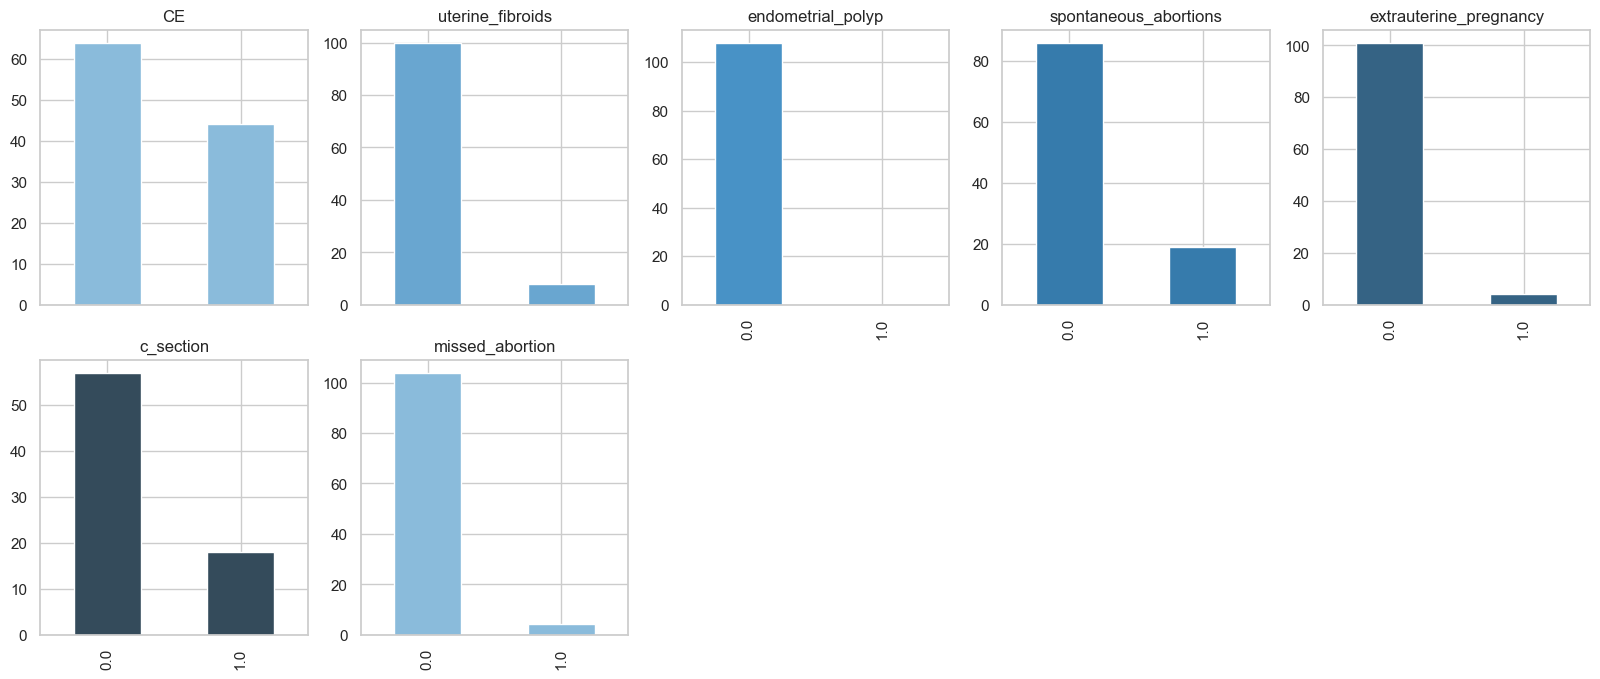

In [10]:
df[[target]+cat].apply(pd.Series.value_counts).plot(kind='bar', subplots=True, figsize=(20, 25), layout=(6, 5), legend=False)

The variable *endometrial_polyp* contained only zeros and was removed during preprocessing. Additionally, *spontaneous_abortions*, *extrauterine_pregnancy*, *c_section*, and *missed_abortion* were excluded due to their negative impact on model performance.

# Preprocessing

In [11]:
# Select subset of features
columns = [
    'CE', 'uterine_fibroids', 'age', 'menstr_cycle_duration', 'endometr_thick',
    'PBAC', 'heavy_menstr_bleeding_day', '17OH', 'FSH', 'LH', 'PRL', 'SHBG',
    'ADIPOQ', 'IL8', 'IL1', 'IL6',
    'IL10', 'TNFa', 'IFN', 'AMH', 'CRP',
    'LEP', 'E2', 'T', 'TSH', 'VAT',
    # 'endometrial_polyp', 'spontaneous_abortions', 'extrauterine_pregnancy', 'c_section', 'missed_abortion'
]


df_before_imputation = df.reset_index()[columns]

## Train-Test Split

In [12]:
X = df_before_imputation.drop([target], axis=1)
y = df_before_imputation[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

## Imputation with MICE

In [13]:
kds = mf.ImputationKernel(
    X_train.reset_index(drop=True),
    random_state=RANDOM_STATE,
)

# Run 10 iterations of MICE
kds.mice(iterations=10)

# Complete training data
X_train_imputed = kds.complete_data()

# Impute test data using models trained on train set
X_test_imputed = kds.impute_new_data(X_test.reset_index(drop=True)).complete_data()

# Scaling

In [14]:
num_cols = X_train_imputed.select_dtypes(include='number').columns

scaler = StandardScaler()
X_train_imputed_scaled = X_train_imputed.copy()
X_train_imputed_scaled[num_cols] = scaler.fit_transform(X_train_imputed[num_cols])

# Resampling with SMOTENC

In [15]:
X_train_imputed_scaled[['uterine_fibroids']] = X_train_imputed_scaled[['uterine_fibroids']].astype('category')
X_test_imputed[['uterine_fibroids']] = X_test_imputed[['uterine_fibroids']].astype('category')

In [16]:
smotenc = SMOTENC(
    sampling_strategy='auto',
    categorical_features=['uterine_fibroids'],
    random_state=RANDOM_STATE
)

X_train_resampled, y_train_resampled = smotenc.fit_resample(
    X_train_imputed_scaled, y_train
)

In [17]:
# Inverse scaling for interpretability
X_train_resampled_original = X_train_resampled.copy()
X_train_resampled_original[num_cols] = scaler.inverse_transform(X_train_resampled[num_cols])

# Feature Engineering

In [18]:
X_train_resampled_original['LEP_ADIPOQ'] = (
    X_train_resampled_original['LEP'] / X_train_resampled_original['ADIPOQ']
)
X_test_imputed['LEP_ADIPOQ'] = (
    X_test_imputed['LEP'] / X_test_imputed['ADIPOQ']
)

X_train_resampled_original['IL1_TNFa'] = (
    X_train_resampled_original['IL1'] / X_train_resampled_original['TNFa']
)
X_test_imputed['IL1_TNFa'] = (
    X_test_imputed['IL1'] / X_test_imputed['TNFa']
)

In [19]:
X_train_ib = X_train_resampled_original.copy()
y_train_b = y_train_resampled.copy()

X_test_i = X_test_imputed.copy()
y_test_df = y_test.copy()

In [20]:
# Ensure categorical flag stored as integers
X_train_ib[['uterine_fibroids']] = X_train_ib[['uterine_fibroids']].astype(int)
X_test_i[['uterine_fibroids']] = X_test_i[['uterine_fibroids']].astype(int)


In [21]:
# Flatten label DataFrames to 1-D numpy arrays for consistency (no change in values)
y_train = np.ravel(y_train_b)
y_test = np.ravel(y_test_df)

In [22]:
# Print shapes / class balance quick check
print("Train X shape:", X_train_ib.shape)
print("Train y shape:", y_train.shape, "  class counts:", pd.Series(y_train).value_counts().to_dict())
print("Test  X shape:", X_test_i.shape)
print("Test  y shape:", y_test.shape, "  class counts:", pd.Series(y_test).value_counts().to_dict())


Train X shape: (88, 27)
Train y shape: (88,)   class counts: {1: 44, 0: 44}
Test  X shape: (33, 27)
Test  y shape: (33,)   class counts: {0: 20, 1: 13}


# Helper utilities: training, evaluation and plotting

In [23]:
def train_xgb_and_evaluate(X_tr, y_tr, X_te, y_te, model_name="model"):
    """
    Train an XGBoost classifier (with same parameters as original), evaluate on test set,
    and return classifier, y_pred, y_pred_proba, cm.
    """
    clf = xgb.XGBClassifier(
        booster='gbtree',
        objective='binary:logistic',
        random_state=RANDOM_STATE,
        eval_metric='auc'
    )
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)
    y_pred_proba = clf.predict_proba(X_te)[:, 1]
    cm = confusion_matrix(y_te, y_pred)
    # Print brief performance summary
    roc_auc = roc_auc_score(y_te, y_pred_proba)
    print(f"\n{model_name} — ROC AUC: {roc_auc:.4f}")
    print(classification_report(y_te, y_pred))
    # plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} — Confusion Matrix")
    plt.show()
    # Plot ROC
    fpr, tpr, _ = roc_curve(y_te, y_pred_proba)
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f'{model_name} Gradient Boosting (AUC={roc_auc:.2f})', lw=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.title(f'{model_name} ROC')
    plt.grid(True); plt.show()
    return clf, y_pred, y_pred_proba, cm


In [24]:
def plot_multiple_rocs(roc_list, auc_list, titles, ncols=5):
    """Plot several ROC curves side-by-side."""
    n = len(roc_list)
    fig, axes = plt.subplots(1, n, figsize=(5*n, ncols))
    if n == 1:
        axes = [axes]
    for ax, (fpr, tpr), aucv, title in zip(axes, roc_list, auc_list, titles):
        ax.plot(fpr, tpr, lw=2, label=f'Gradient Boosting (AUC={aucv:.2f})')
        ax.plot([0, 1], [0, 1], '--', color='gray', label='Random Guess')
        ax.set_title(title)
        ax.set_xlabel('FPR'); ax.set_ylabel('TPR')
        ax.legend(loc='lower right', frameon=True)
        ax.grid(True)

    fig.suptitle('ROC-AUC for Multiple Models', fontsize=20)
    plt.tight_layout()
    plt.savefig('./images/roc_aucs.png', dpi=300, bbox_inches='tight')
    plt.show()


In [25]:
def plot_multiple_prs(pr_list, pr_auc_list, titles, ncols=5):
    """Plot several precision-recall curves side-by-side."""
    n = len(pr_list)
    fig, axes = plt.subplots(1, n, figsize=(5*n, ncols))
    if n == 1:
        axes = [axes]
    for ax, (prec, rec), prauc, title in zip(axes, pr_list, pr_auc_list, titles):
        ax.plot(rec, prec, lw=2, label=f'Gradient Boosting (PR-AUC={prauc:.2f})')
        ax.set_title(title)
        ax.set_xlabel('Recall'); ax.set_ylabel('Precision')
        ax.legend(loc='upper right', frameon=True)
        ax.grid(True)
    
    fig.suptitle('PR-AUC for Multiple Models', fontsize=20)
    plt.tight_layout()
    plt.savefig('./images/pr_aucs.png', dpi=300, bbox_inches='tight')
    plt.show()


# 1) Model variant 1

In [26]:
# Prepare scaled copy for SFS
scaler = StandardScaler()
X_train_sfs = X_train_ib.drop(['LEP_ADIPOQ', 'IL1_TNFa'], axis=1).copy()
X_train_sfs = pd.DataFrame(scaler.fit_transform(X_train_sfs), columns=X_train_sfs.columns)


In [27]:
# Setup LogisticRegression used as SFS estimator
lr_for_sfs = LogisticRegression(
    penalty='l1',
    C=1.0,
    solver='liblinear',
    max_iter=100,
    random_state=RANDOM_STATE,
    class_weight='balanced'
)

sfs_lr = SFS(
    lr_for_sfs,
    k_features='best',  # choose best subset
    forward=True,       # forward selection
    floating=True,      # enable floating selection
    scoring='roc_auc',
    verbose=2,
    cv=5
)
sfs_lr = sfs_lr.fit(X_train_sfs, y_train)

print("Model 1 — Selected features (SFS):", sfs_lr.k_feature_names_)
print("Model 1 — Best SFS ROC-AUC (CV):", sfs_lr.k_score_)

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.7s finished

[2025-10-03 00:05:21] Features: 1/25 -- score: 0.6804012345679012[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.6s finished

[2025-10-03 00:05:22] Features: 2/25 -- score: 0.7561728395061729[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.6s finished

[2025-10-03 00:05:22] Features: 2/25 -- score: 0.7561728395061729[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2025-10-03 00:05:23] Features: 3/25 -- score: 0.7703703703703704[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2025-10-03 00:05:23] Features: 3/25 -- score: 0.7703703703703704[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished

[2025-10-03 00:05:23] Features: 4/25 --

Model 1 — Selected features (SFS): ('heavy_menstr_bleeding_day', 'ADIPOQ', 'IL1', 'TNFa', 'IFN', 'CRP', 'T')
Model 1 — Best SFS ROC-AUC (CV): 0.812037037037037


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.6s finished

[2025-10-03 00:05:48] Features: 25/25 -- score: 0.7040123456790124

In [28]:
predictors_model1 = list(sfs_lr.k_feature_names_)
X_train_m1 = X_train_ib[predictors_model1].copy()
X_test_m1 = X_test_i[predictors_model1].copy()



Model 1 — ROC AUC: 0.7038
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        20
           1       0.64      0.54      0.58        13

    accuracy                           0.70        33
   macro avg       0.68      0.67      0.67        33
weighted avg       0.69      0.70      0.69        33



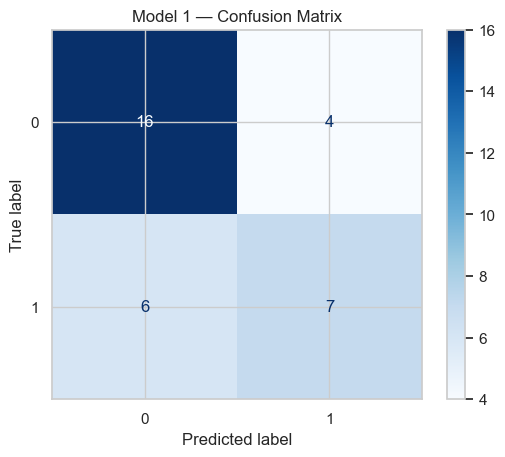

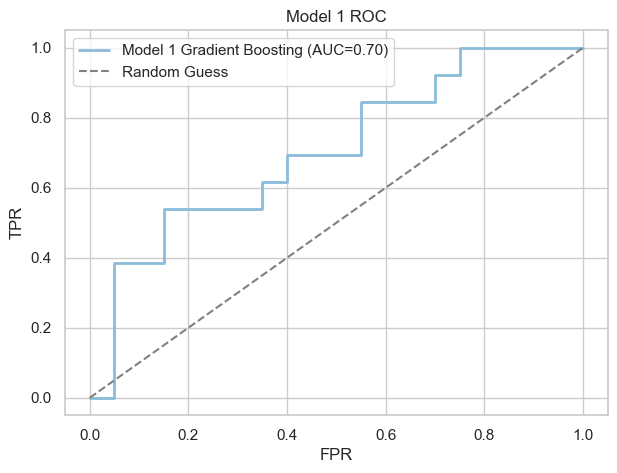

In [29]:
# Train & evaluate model 1 (XGBoost)
m1, y_pred_m1, y_pred_proba_m1, cm_m1 = train_xgb_and_evaluate(
    X_train_m1, y_train, X_test_m1, y_test, model_name="Model 1"
)


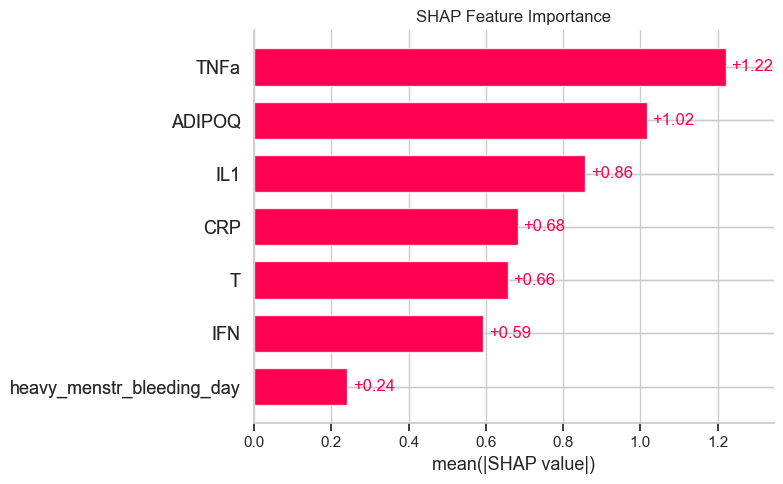

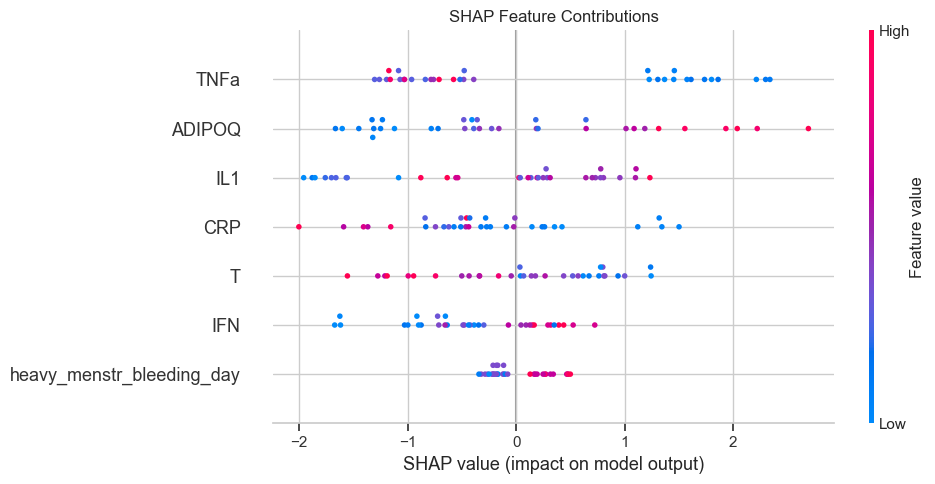

In [30]:
explainer1 = shap.TreeExplainer(m1, X_train_m1)
shap_values_1 = explainer1(X_test_m1)

# Bar plot
plt.figure(figsize=(22, 5))
shap.plots.bar(shap_values_1, show=False, max_display=len(X_test_m1.columns))
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.savefig('./images/shap_plots_m1_bar.png', dpi=300, bbox_inches='tight')
plt.show()

# Beeswarm plot
plt.figure(figsize=(10, 5))
shap.plots.beeswarm(shap_values_1, show=False, max_display=len(X_test_m1.columns), plot_size=None)
plt.title('SHAP Feature Contributions')
plt.tight_layout()
plt.savefig('./images/shap_plots_m1_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()

# 2) Model variant 2

In [31]:
X_train_sfs2 = X_train_ib.drop(['LEP_ADIPOQ', 'IL1', 'TNFa'], axis=1).copy()
X_train_sfs2 = pd.DataFrame(scaler.fit_transform(X_train_sfs2), columns=X_train_sfs2.columns)

In [32]:
sfs_lr2 = SFS(
    lr_for_sfs,
    k_features='best',
    forward=True,
    floating=True,
    scoring='roc_auc',
    verbose=2,
    cv=5
)
sfs_lr2 = sfs_lr2.fit(X_train_sfs2, y_train)

print("Model 2 — Selected features (SFS):", sfs_lr2.k_feature_names_)
print("Model 2 — Best SFS ROC-AUC (CV):", sfs_lr2.k_score_)

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.5s finished

[2025-10-03 00:05:52] Features: 1/24 -- score: 0.6804012345679012[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.5s finished

[2025-10-03 00:05:52] Features: 2/24 -- score: 0.7561728395061729[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.5s finished

[2025-10-03 00:05:52] Features: 2/24 -- score: 0.7561728395061729[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2025-10-03 00:05:53] Features: 3/24 -- score: 0.7703703703703704[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2025-10-03 00:05:53] Features: 3/24 -- score: 0.7703703703703704[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished

[2025-10-03 00:05:54] Features: 4/24 --

Model 2 — Selected features (SFS): ('17OH', 'ADIPOQ', 'IL8', 'CRP', 'E2', 'T', 'VAT')
Model 2 — Best SFS ROC-AUC (CV): 0.7858024691358024


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.5s finished

[2025-10-03 00:06:24] Features: 24/24 -- score: 0.6595679012345679

In [33]:
predictors_model2 = list(sfs_lr2.k_feature_names_)
X_train_m2 = X_train_ib[predictors_model2].copy()
X_test_m2 = X_test_i[predictors_model2].copy()


Model 2 — ROC AUC: 0.6731
              precision    recall  f1-score   support

           0       0.73      0.55      0.63        20
           1       0.50      0.69      0.58        13

    accuracy                           0.61        33
   macro avg       0.62      0.62      0.60        33
weighted avg       0.64      0.61      0.61        33



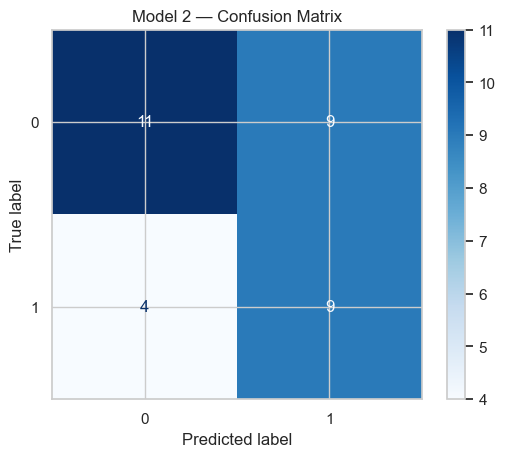

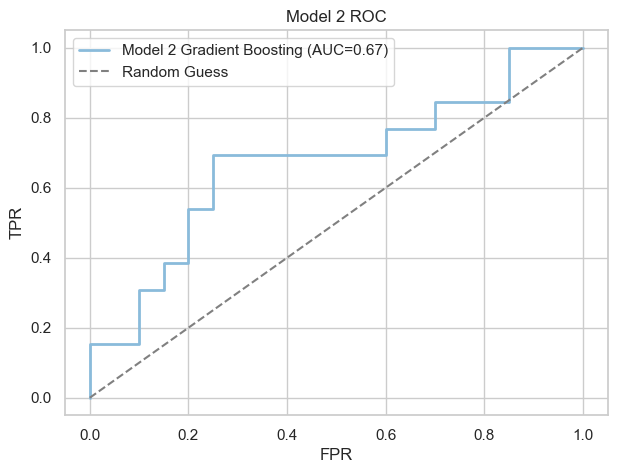

In [34]:
m2, y_pred_m2, y_pred_proba_m2, cm_m2 = train_xgb_and_evaluate(
    X_train_m2, y_train, X_test_m2, y_test, model_name="Model 2"
)


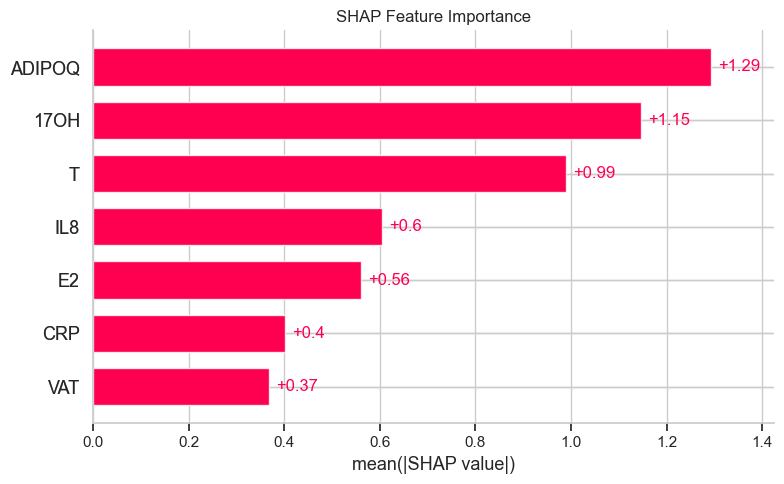

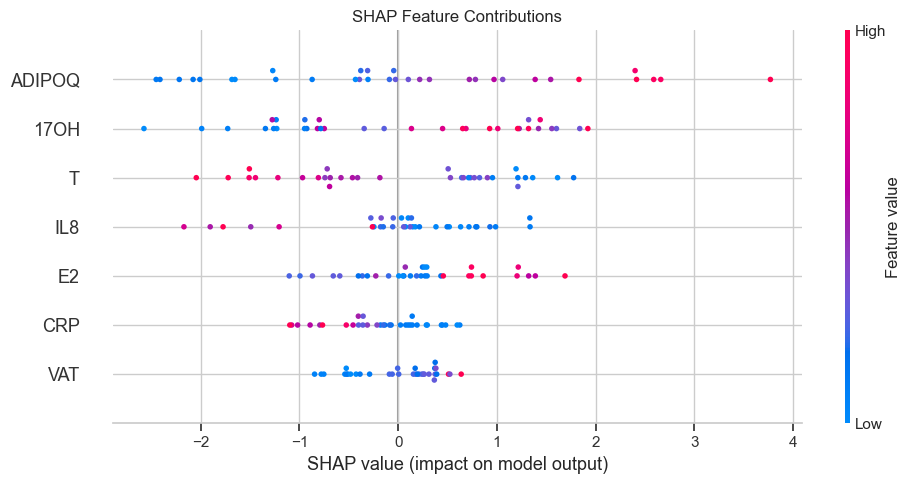

In [35]:
explainer2 = shap.TreeExplainer(m2, X_train_m2)
shap_values_2 = explainer2(X_test_m2)

# Bar plot
plt.figure(figsize=(22, 5))
shap.plots.bar(shap_values_2, show=False, max_display=len(X_test_m2.columns))
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.savefig('./images/shap_plots_m2_bar.png', dpi=300, bbox_inches='tight')
plt.show()

# Beeswarm plot
plt.figure(figsize=(10, 5))
shap.plots.beeswarm(shap_values_2, show=False, max_display=len(X_test_m2.columns), plot_size=None)
plt.title('SHAP Feature Contributions')
plt.tight_layout()
plt.savefig('./images/shap_plots_m2_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()

# 3) Model variant 3

In [36]:
X_train_sfs3 = X_train_ib.drop(['LEP', 'ADIPOQ', 'IL1_TNFa'], axis=1).copy()
X_train_sfs3 = pd.DataFrame(scaler.fit_transform(X_train_sfs3), columns=X_train_sfs3.columns)

In [37]:
sfs_lr3 = SFS(
    lr_for_sfs,
    k_features='best',
    forward=True,
    floating=True,
    scoring='roc_auc',
    verbose=2,
    cv=5
)
sfs_lr3 = sfs_lr3.fit(X_train_sfs3, y_train)

print("Model 3 — Selected features (SFS):", sfs_lr3.k_feature_names_)
print("Model 3 — Best SFS ROC-AUC (CV):", sfs_lr3.k_score_)

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.5s finished

[2025-10-03 00:06:27] Features: 1/24 -- score: 0.6530864197530863[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.2s finished

[2025-10-03 00:06:27] Features: 2/24 -- score: 0.6787037037037037[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.2s finished

[2025-10-03 00:06:27] Features: 2/24 -- score: 0.6787037037037037[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2025-10-03 00:06:28] Features: 3/24 -- score: 0.711111111111111[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2025-10-03 00:06:28] Features: 3/24 -- score: 0.711111111111111[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished

[2025-10-03 00:06:28] Features: 4/24 -- s

Model 3 — Selected features (SFS): ('PBAC', 'heavy_menstr_bleeding_day', '17OH', 'IL1', 'IL6', 'TNFa', 'CRP', 'E2', 'T')
Model 3 — Best SFS ROC-AUC (CV): 0.7632716049382716


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished

[2025-10-03 00:06:50] Features: 24/24 -- score: 0.6546296296296297

In [38]:
predictors_model3 = list(sfs_lr3.k_feature_names_)
X_train_m3 = X_train_ib[predictors_model3].copy()
X_test_m3 = X_test_i[predictors_model3].copy()


Model 3 — ROC AUC: 0.6769
              precision    recall  f1-score   support

           0       0.67      0.50      0.57        20
           1       0.44      0.62      0.52        13

    accuracy                           0.55        33
   macro avg       0.56      0.56      0.54        33
weighted avg       0.58      0.55      0.55        33



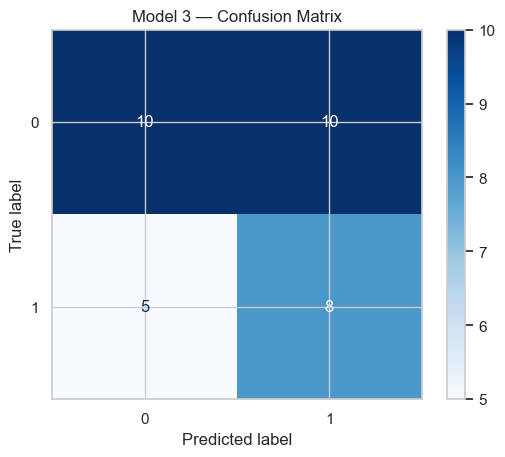

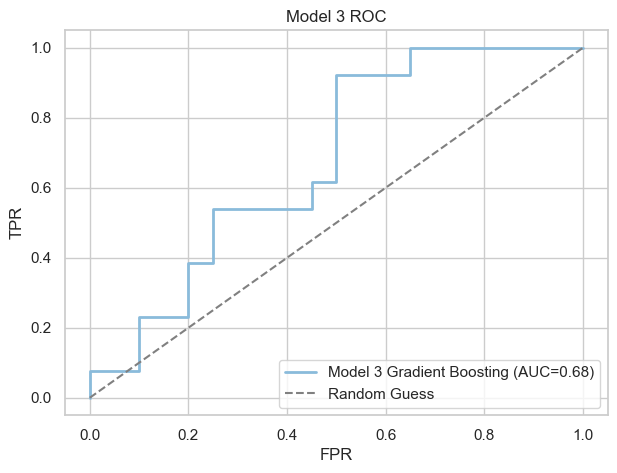

In [39]:
m3, y_pred_m3, y_pred_proba_m3, cm_m3 = train_xgb_and_evaluate(
    X_train_m3, y_train, X_test_m3, y_test, model_name="Model 3"
)


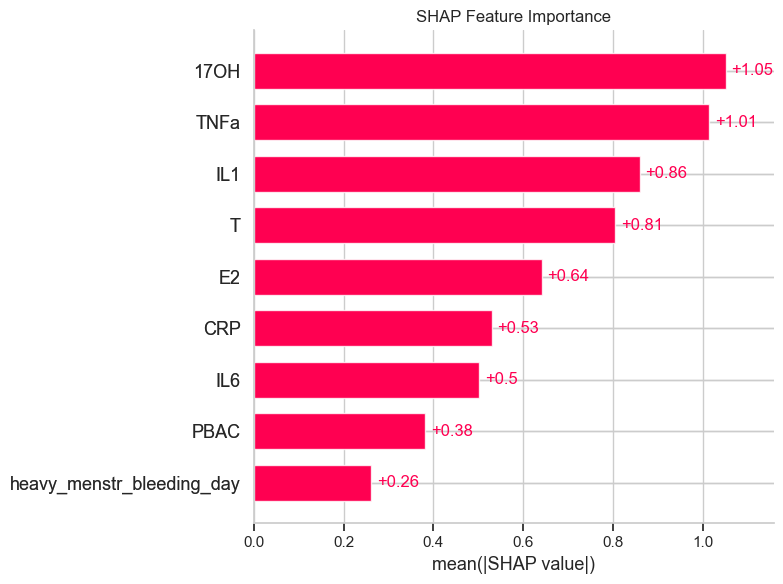

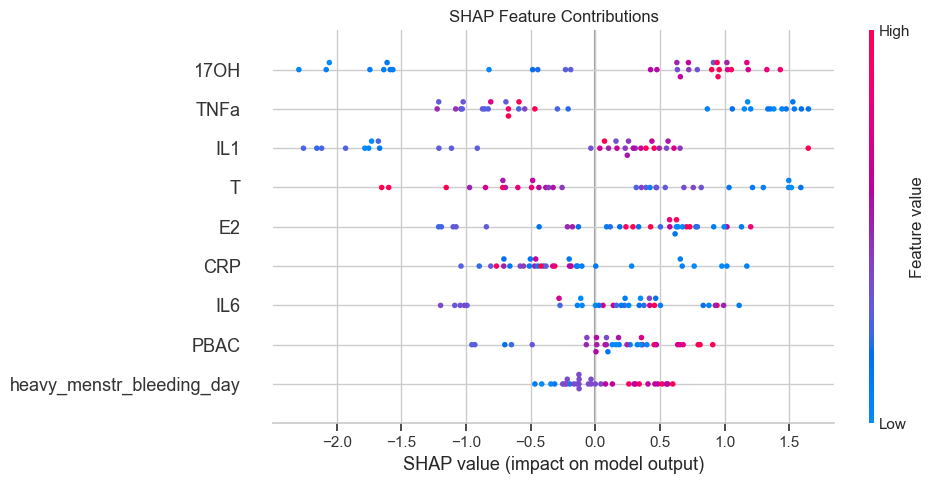

In [40]:
explainer3 = shap.TreeExplainer(m3, X_train_m3)
shap_values_3 = explainer3(X_test_m3)

# Bar plot
plt.figure(figsize=(22, 5))
shap.plots.bar(shap_values_3, show=False, max_display=len(X_test_m3.columns))
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.savefig('./images/shap_plots_m3_bar.png', dpi=300, bbox_inches='tight')
plt.show()

# Beeswarm plot
plt.figure(figsize=(10, 5))
shap.plots.beeswarm(shap_values_3, show=False, max_display=len(X_test_m3.columns), plot_size=None)
plt.title('SHAP Feature Contributions')
plt.tight_layout()
plt.savefig('./images/shap_plots_m3_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()

# 4) Model variant 4


In [41]:
X_train_sfs4 = X_train_ib.drop(['LEP', 'ADIPOQ', 'IL1', 'TNFa'], axis=1).copy()
X_train_sfs4 = pd.DataFrame(scaler.fit_transform(X_train_sfs4), columns=X_train_sfs4.columns)

In [42]:
sfs_lr4 = SFS(
    lr_for_sfs,
    k_features='best',
    forward=True,
    floating=True,
    scoring='roc_auc',
    verbose=2,
    cv=5
)
sfs_lr4 = sfs_lr4.fit(X_train_sfs4, y_train)

print("Model 4 — Selected features (SFS):", sfs_lr4.k_feature_names_)
print("Model 4 — Best SFS ROC-AUC (CV):", sfs_lr4.k_score_)


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished

[2025-10-03 00:06:52] Features: 1/23 -- score: 0.6530864197530863[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.3s finished

[2025-10-03 00:06:52] Features: 2/23 -- score: 0.6787037037037037[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.3s finished

[2025-10-03 00:06:52] Features: 2/23 -- score: 0.6787037037037037[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2025-10-03 00:06:53] Features: 3/23 -- score: 0.711111111111111[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2025-10-03 00:06:53] Features: 3/23 -- score: 0.711111111111111[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished

[2025-10-03 00:06:53] Features: 4/23 -- s

Model 4 — Selected features (SFS): ('FSH', 'SHBG', 'IFN', 'CRP', 'LEP_ADIPOQ')
Model 4 — Best SFS ROC-AUC (CV): 0.7620370370370371


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.3s finished

[2025-10-03 00:07:11] Features: 23/23 -- score: 0.5959876543209877

In [43]:
predictors_model4 = list(sfs_lr4.k_feature_names_)
X_train_m4 = X_train_ib[predictors_model4].copy()
X_test_m4 = X_test_i[predictors_model4].copy()


Model 4 — ROC AUC: 0.7577
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        20
           1       0.57      0.62      0.59        13

    accuracy                           0.67        33
   macro avg       0.65      0.66      0.66        33
weighted avg       0.67      0.67      0.67        33



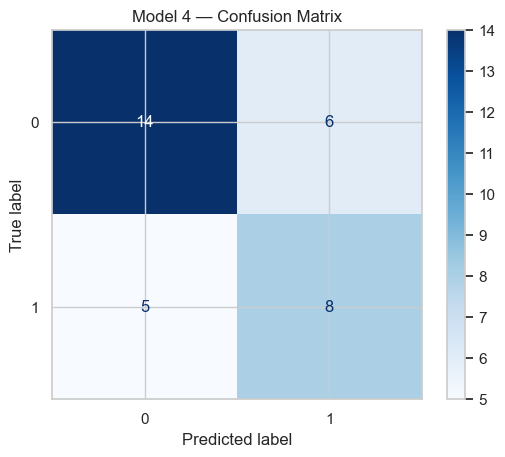

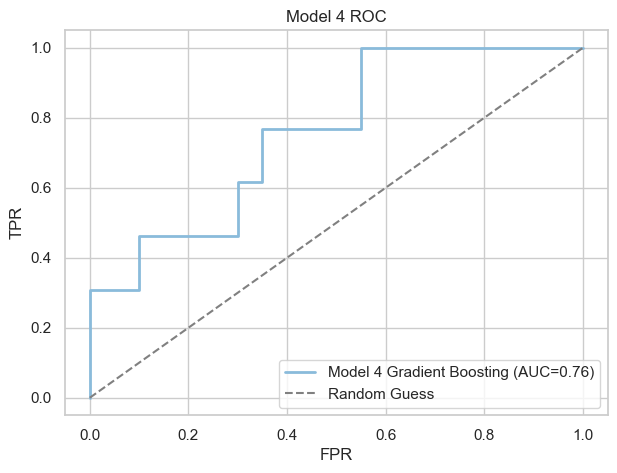

In [44]:
m4, y_pred_m4, y_pred_proba_m4, cm_m4 = train_xgb_and_evaluate(
    X_train_m4, y_train, X_test_m4, y_test, model_name="Model 4"
)


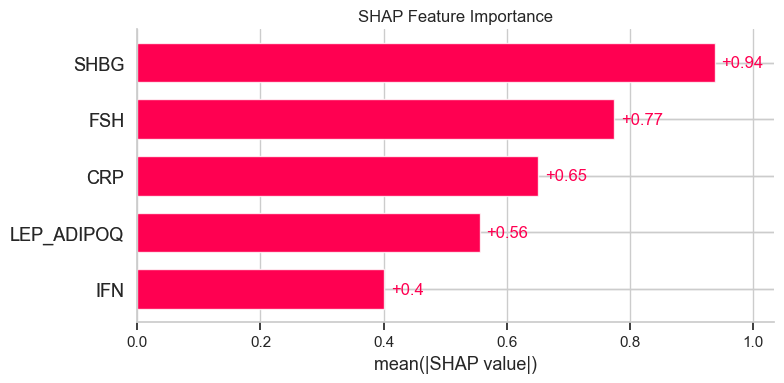

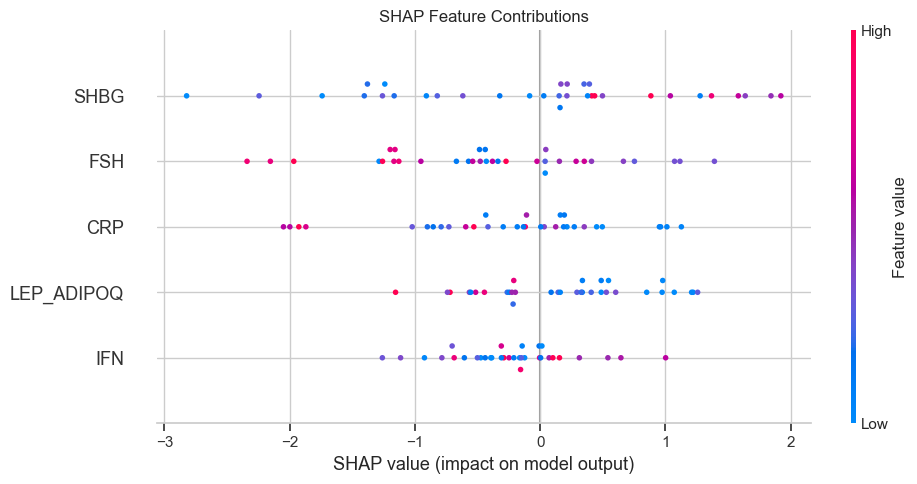

In [45]:
explainer4 = shap.TreeExplainer(m4, X_train_m4)
shap_values_4 = explainer4(X_test_m4)

# Bar plot
plt.figure(figsize=(22, 5))
shap.plots.bar(shap_values_4, show=False, max_display=len(X_test_m4.columns))
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.savefig('./images/shap_plots_m4_bar.png', dpi=300, bbox_inches='tight')
plt.show()

# Beeswarm plot
plt.figure(figsize=(10, 5))
shap.plots.beeswarm(shap_values_4, show=False, max_display=len(X_test_m4.columns), plot_size=None)
plt.title('SHAP Feature Contributions')
plt.tight_layout()
plt.savefig('./images/shap_plots_m4_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()

# 5) Model variant 5

In [46]:
predictors_model5 = ['FSH', 'SHBG', 'endometr_thick', 'CRP', 'LEP_ADIPOQ']
X_train_m5 = X_train_ib[predictors_model5].copy()
X_test_m5 = X_test_i[predictors_model5].copy()



Model 5 — ROC AUC: 0.7692
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        20
           1       0.60      0.69      0.64        13

    accuracy                           0.70        33
   macro avg       0.69      0.70      0.69        33
weighted avg       0.71      0.70      0.70        33



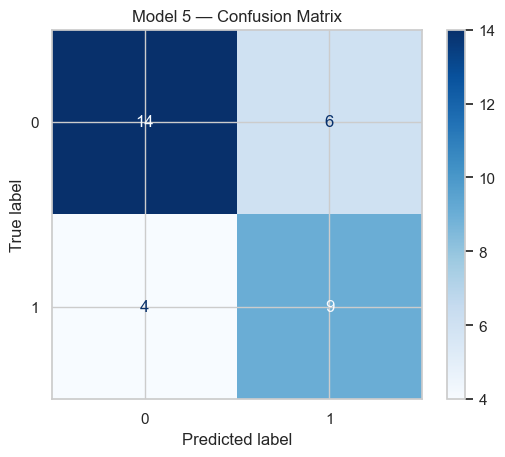

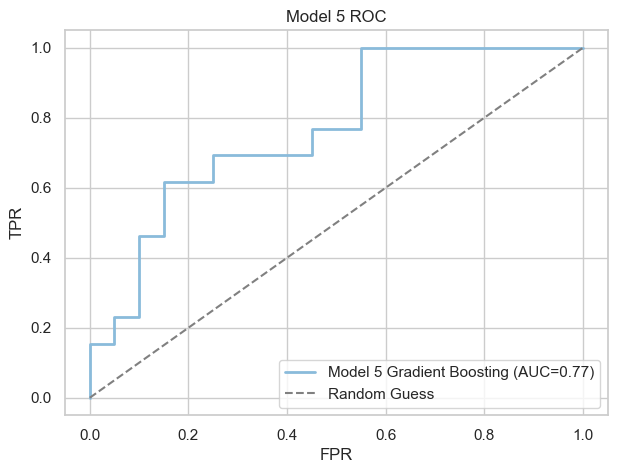

In [47]:
m5, y_pred_m5, y_pred_proba_m5, cm_m5 = train_xgb_and_evaluate(
    X_train_m5, y_train, X_test_m5, y_test, model_name="Model 5"
)


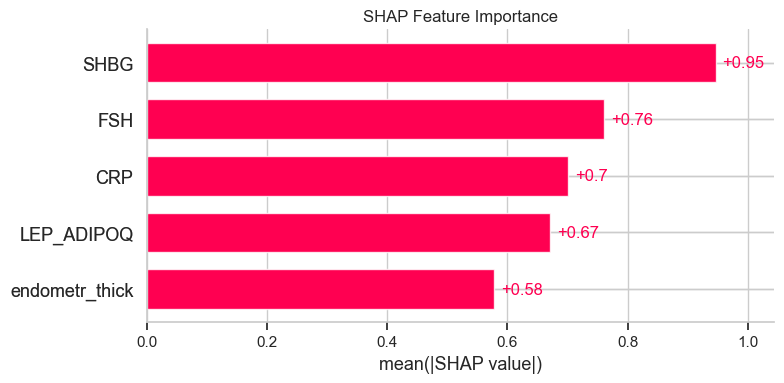

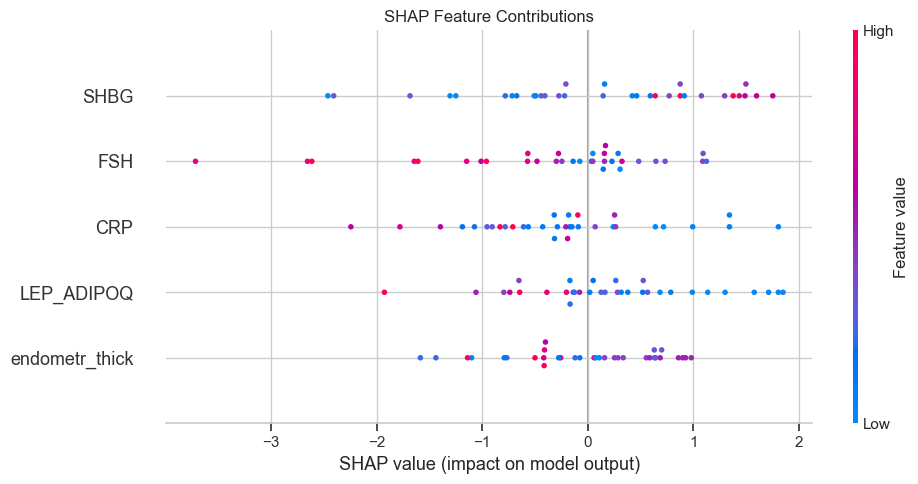

In [48]:
explainer5 = shap.TreeExplainer(m5, X_train_m5)
shap_values_5 = explainer5(X_test_m5)

# Bar plot
plt.figure(figsize=(22, 5))
shap.plots.bar(shap_values_5, show=False, max_display=len(X_test_m5.columns))
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.savefig('./images/shap_plots_m5_bar.png', dpi=300, bbox_inches='tight')
plt.show()

# Beeswarm plot
plt.figure(figsize=(10, 5))
shap.plots.beeswarm(shap_values_5, show=False, max_display=len(X_test_m5.columns), plot_size=None)
plt.title('SHAP Feature Contributions')
plt.tight_layout()
plt.savefig('./images/shap_plots_m5_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary: classification reports

In [49]:
print("\n\n----- Classification reports (Models 1..5) -----\n")
print("Model 1:\n", classification_report(y_test, y_pred_m1))
print("Model 2:\n", classification_report(y_test, y_pred_m2))
print("Model 3:\n", classification_report(y_test, y_pred_m3))
print("Model 4:\n", classification_report(y_test, y_pred_m4))
print("Model 5:\n", classification_report(y_test, y_pred_m5))



----- Classification reports (Models 1..5) -----

Model 1:
               precision    recall  f1-score   support

           0       0.73      0.80      0.76        20
           1       0.64      0.54      0.58        13

    accuracy                           0.70        33
   macro avg       0.68      0.67      0.67        33
weighted avg       0.69      0.70      0.69        33

Model 2:
               precision    recall  f1-score   support

           0       0.73      0.55      0.63        20
           1       0.50      0.69      0.58        13

    accuracy                           0.61        33
   macro avg       0.62      0.62      0.60        33
weighted avg       0.64      0.61      0.61        33

Model 3:
               precision    recall  f1-score   support

           0       0.67      0.50      0.57        20
           1       0.44      0.62      0.52        13

    accuracy                           0.55        33
   macro avg       0.56      0.56      0.54   

# Confusion matrices plot

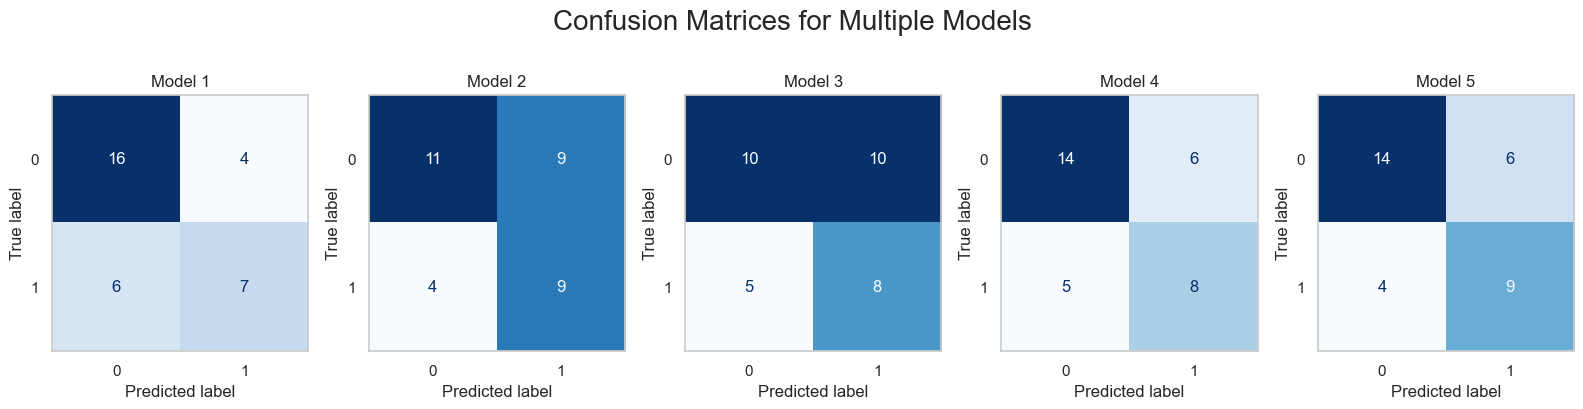

In [50]:
fig, axes = plt.subplots(1, 5, figsize=(16, 4))
cms = [cm_m1, cm_m2, cm_m3, cm_m4, cm_m5]
titles = ["Model 1", "Model 2", "Model 3", "Model 4", "Model 5"]
for ax, cm, title in zip(axes, cms, titles):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
    ax.set_title(title)
    ax.grid(False)

fig.suptitle('Confusion Matrices for Multiple Models', fontsize=20)
plt.tight_layout()
plt.savefig('./images/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()


# ROC curves + AUCs for all models

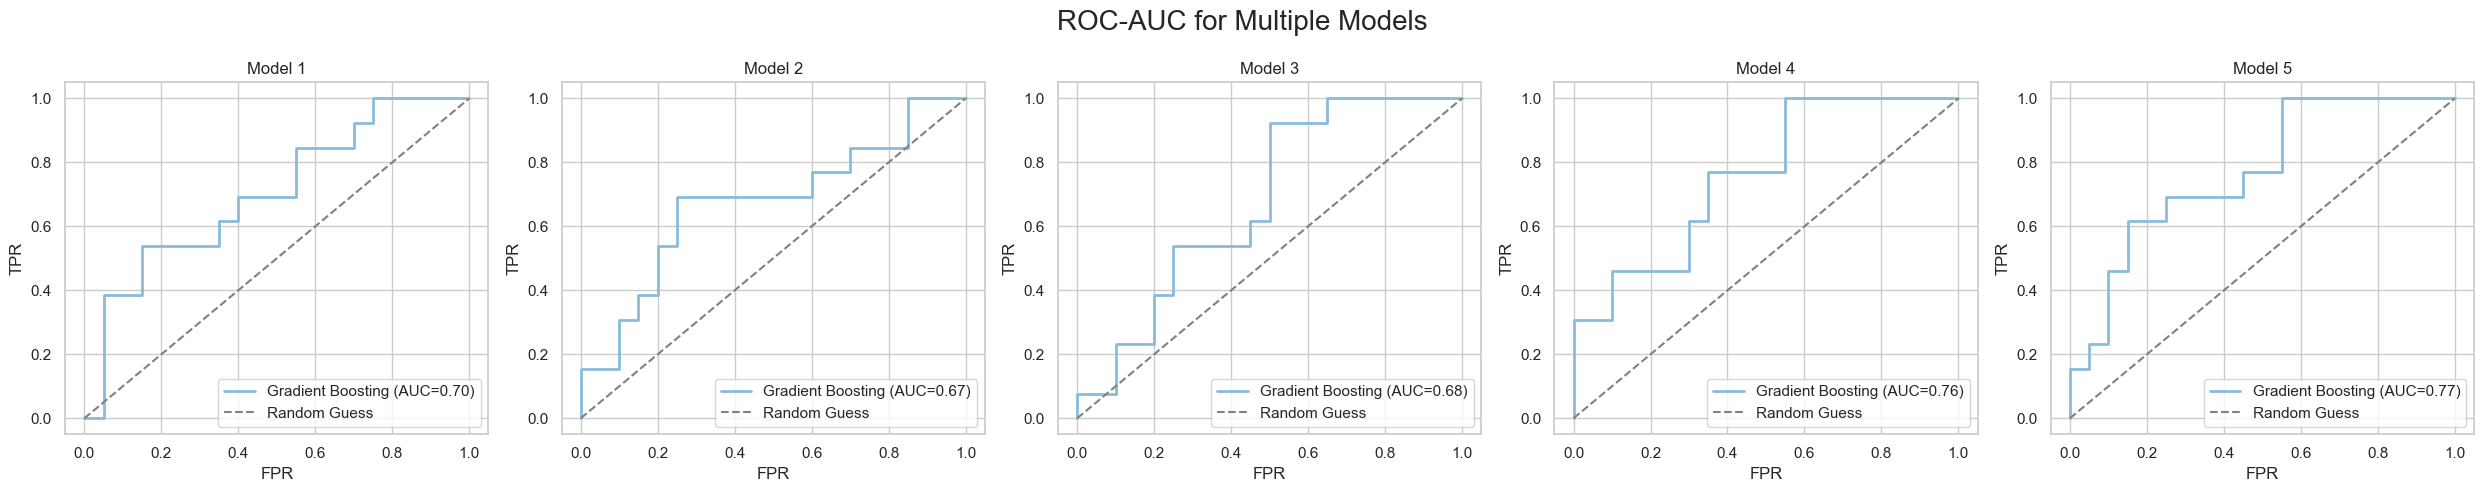

In [51]:
fpr_m1, tpr_m1, _ = roc_curve(y_test, y_pred_proba_m1); roc_auc_m1 = roc_auc_score(y_test, y_pred_proba_m1)
fpr_m2, tpr_m2, _ = roc_curve(y_test, y_pred_proba_m2); roc_auc_m2 = roc_auc_score(y_test, y_pred_proba_m2)
fpr_m3, tpr_m3, _ = roc_curve(y_test, y_pred_proba_m3); roc_auc_m3 = roc_auc_score(y_test, y_pred_proba_m3)
fpr_m4, tpr_m4, _ = roc_curve(y_test, y_pred_proba_m4); roc_auc_m4 = roc_auc_score(y_test, y_pred_proba_m4)
fpr_m5, tpr_m5, _ = roc_curve(y_test, y_pred_proba_m5); roc_auc_m5 = roc_auc_score(y_test, y_pred_proba_m5)

plot_multiple_rocs(
    [(fpr_m1, tpr_m1), (fpr_m2, tpr_m2), (fpr_m3, tpr_m3), (fpr_m4, tpr_m4), (fpr_m5, tpr_m5)],
    [roc_auc_m1, roc_auc_m2, roc_auc_m3, roc_auc_m4, roc_auc_m5],
    titles
)


# DeLong test pairwise comparisons of ROC-AUC

In [52]:
pairs = [
    ("Model 1", y_pred_proba_m1, "Model 2", y_pred_proba_m2, roc_auc_m1, roc_auc_m2),
    ("Model 1", y_pred_proba_m1, "Model 3", y_pred_proba_m3, roc_auc_m1, roc_auc_m3),
    ("Model 1", y_pred_proba_m1, "Model 4", y_pred_proba_m4, roc_auc_m1, roc_auc_m4),
    ("Model 1", y_pred_proba_m1, "Model 5", y_pred_proba_m5, roc_auc_m1, roc_auc_m5),

    ("Model 2", y_pred_proba_m2, "Model 3", y_pred_proba_m3, roc_auc_m2, roc_auc_m3),
    ("Model 2", y_pred_proba_m2, "Model 4", y_pred_proba_m4, roc_auc_m2, roc_auc_m4),
    ("Model 2", y_pred_proba_m2, "Model 5", y_pred_proba_m5, roc_auc_m2, roc_auc_m5),

    ("Model 3", y_pred_proba_m3, "Model 4", y_pred_proba_m4, roc_auc_m3, roc_auc_m4),
    ("Model 3", y_pred_proba_m3, "Model 5", y_pred_proba_m5, roc_auc_m3, roc_auc_m5),

    ("Model 4", y_pred_proba_m4, "Model 5", y_pred_proba_m5, roc_auc_m4, roc_auc_m5),
]

for a_name, a_probs, b_name, b_probs, a_auc, b_auc in pairs:
    z, p, ci_a, ci_b = Delong_test(y_test, a_probs, b_probs, return_ci=True)
    print(f"\nDeLong — {a_name} (AUC={a_auc:.2f}) vs {b_name} (AUC={b_auc:.2f})")
    print(f"  Z = {z:.3f}, p = {p:.4f}")
    print(f"  {a_name} AUC 95% CI: {ci_a}")
    print(f"  {b_name} AUC 95% CI: {ci_b}")


DeLong — Model 1 (AUC=0.70) vs Model 2 (AUC=0.67)
  Z = -0.347, p = 0.7285
  Model 1 AUC 95% CI: (0.5170258531575793, 0.8906664545347285)
  Model 2 AUC 95% CI: (0.47162726743378347, 0.8745265787200626)

DeLong — Model 1 (AUC=0.70) vs Model 3 (AUC=0.68)
  Z = -0.314, p = 0.7537
  Model 1 AUC 95% CI: (0.5170258531575793, 0.8906664545347285)
  Model 3 AUC 95% CI: (0.4915962749726849, 0.8622498788734693)

DeLong — Model 1 (AUC=0.70) vs Model 4 (AUC=0.76)
  Z = -0.605, p = 0.5452
  Model 1 AUC 95% CI: (0.5170258531575793, 0.8906664545347285)
  Model 4 AUC 95% CI: (0.5912521395915334, 0.9241324757930821)

DeLong — Model 1 (AUC=0.70) vs Model 5 (AUC=0.77)
  Z = -0.678, p = 0.4980
  Model 1 AUC 95% CI: (0.5170258531575793, 0.8906664545347285)
  Model 5 AUC 95% CI: (0.6048761581989482, 0.9335853802625903)

DeLong — Model 2 (AUC=0.67) vs Model 3 (AUC=0.68)
  Z = -0.033, p = 0.9739
  Model 2 AUC 95% CI: (0.47162726743378347, 0.8745265787200626)
  Model 3 AUC 95% CI: (0.4915962749726849, 0.862249

# PR curves + PR-AUC

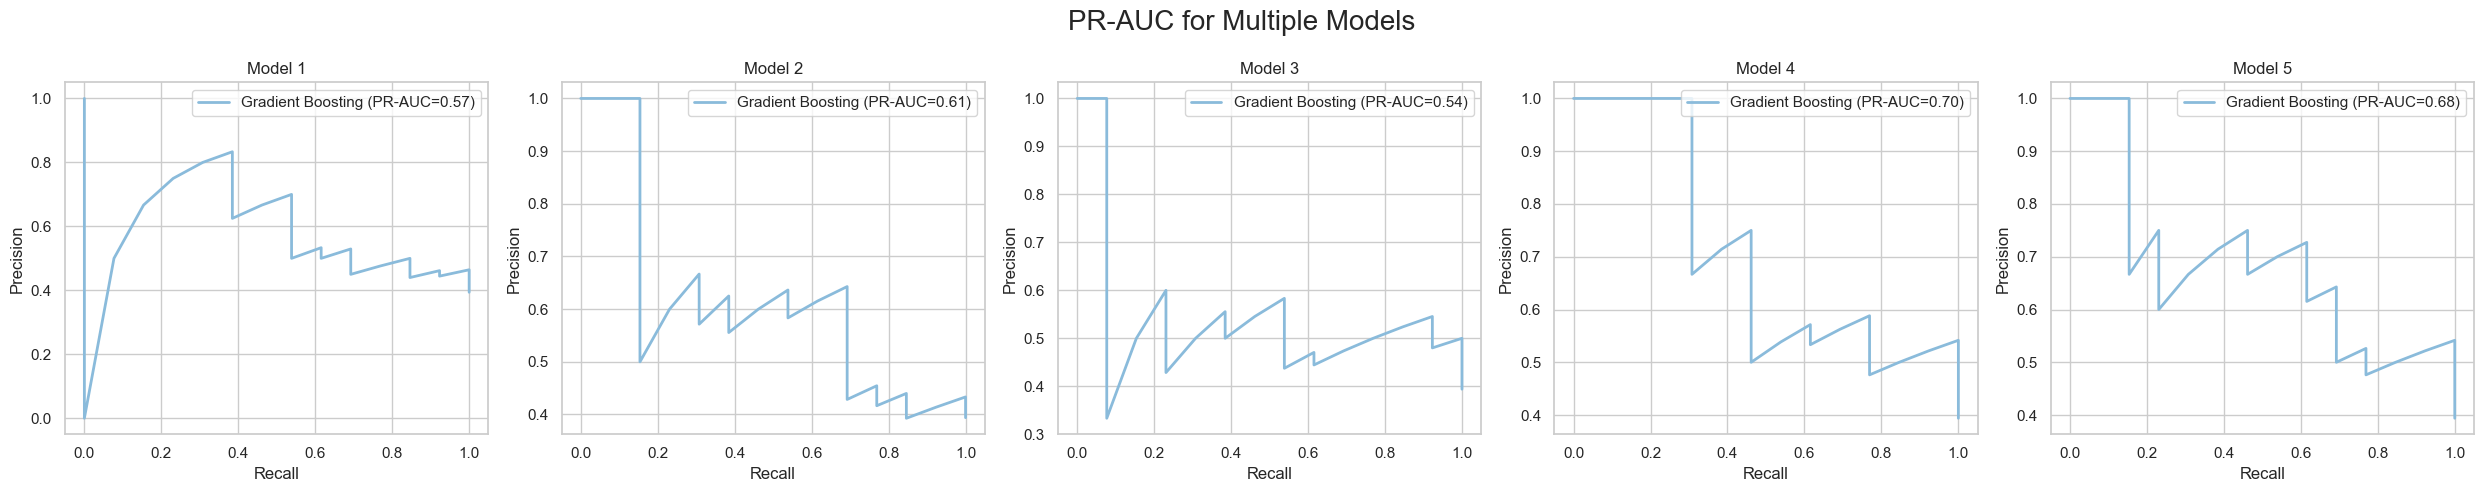

In [53]:
precision_m1, recall_m1, _ = precision_recall_curve(y_test, y_pred_proba_m1); pr_auc_m1 = auc(recall_m1, precision_m1)
precision_m2, recall_m2, _ = precision_recall_curve(y_test, y_pred_proba_m2); pr_auc_m2 = auc(recall_m2, precision_m2)
precision_m3, recall_m3, _ = precision_recall_curve(y_test, y_pred_proba_m3); pr_auc_m3 = auc(recall_m3, precision_m3)
precision_m4, recall_m4, _ = precision_recall_curve(y_test, y_pred_proba_m4); pr_auc_m4 = auc(recall_m4, precision_m4)
precision_m5, recall_m5, _ = precision_recall_curve(y_test, y_pred_proba_m5); pr_auc_m5 = auc(recall_m5, precision_m5)

plot_multiple_prs(
    [(precision_m1, recall_m1), (precision_m2, recall_m2), (precision_m3, recall_m3), (precision_m4, recall_m4), (precision_m5, recall_m5)],
    [pr_auc_m1, pr_auc_m2, pr_auc_m3, pr_auc_m4, pr_auc_m5],
    titles
)


# Bootstrap PR-AUC pairwise comparison

In [54]:
def pr_auc_score(y_true, y_proba):
    p, r, _ = precision_recall_curve(y_true, y_proba)
    return auc(r, p)

def bootstrap_pr_auc(y_true, proba_a, proba_b, n_bootstraps=1000, random_seed=RANDOM_STATE):
    rng = np.random.RandomState(random_seed)
    diffs = []
    n = len(y_true)
    for _ in range(n_bootstraps):
        idx = rng.choice(n, n, replace=True)
        a = pr_auc_score(y_true[idx], proba_a[idx])
        b = pr_auc_score(y_true[idx], proba_b[idx])
        diffs.append(a - b)
    diffs = np.array(diffs)
    ci_lower, ci_upper = np.percentile(diffs, [2.5, 97.5])
    p_value = 2 * min(np.mean(diffs <= 0), np.mean(diffs >= 0))
    return ci_lower, ci_upper, p_value

# pairwise bootstrap for PR-AUC
for a_name, a_probs, b_name, b_probs, a_pr, b_pr in [
    ("Model 1", y_pred_proba_m1, "Model 2", y_pred_proba_m2, pr_auc_m1, pr_auc_m2),
    ("Model 1", y_pred_proba_m1, "Model 3", y_pred_proba_m3, pr_auc_m1, pr_auc_m3),
    ("Model 1", y_pred_proba_m1, "Model 4", y_pred_proba_m4, pr_auc_m1, pr_auc_m4),
    ("Model 1", y_pred_proba_m1, "Model 5", y_pred_proba_m5, pr_auc_m1, pr_auc_m5),

    ("Model 2", y_pred_proba_m2, "Model 3", y_pred_proba_m3, pr_auc_m2, pr_auc_m3),
    ("Model 2", y_pred_proba_m2, "Model 4", y_pred_proba_m4, pr_auc_m2, pr_auc_m4),
    ("Model 2", y_pred_proba_m2, "Model 5", y_pred_proba_m5, pr_auc_m2, pr_auc_m5),

    ("Model 3", y_pred_proba_m3, "Model 4", y_pred_proba_m4, pr_auc_m3, pr_auc_m4),
    ("Model 3", y_pred_proba_m3, "Model 5", y_pred_proba_m5, pr_auc_m3, pr_auc_m5),

    ("Model 4", y_pred_proba_m4, "Model 5", y_pred_proba_m5, pr_auc_m4, pr_auc_m5),
]:
    ci_l, ci_u, p_val = bootstrap_pr_auc(y_test, a_probs, b_probs)
    print(f"\nPR-AUC: {a_name}={a_pr:.3f} vs {b_name}={b_pr:.3f}")
    print(f"  Difference 95% CI: [{ci_l:.3f}, {ci_u:.3f}]  p ≈ {p_val:.3f}")


PR-AUC: Model 1=0.565 vs Model 2=0.608
  Difference 95% CI: [-0.283, 0.265]  p ≈ 0.828

PR-AUC: Model 1=0.565 vs Model 3=0.537
  Difference 95% CI: [-0.193, 0.324]  p ≈ 0.720

PR-AUC: Model 1=0.565 vs Model 3=0.537
  Difference 95% CI: [-0.193, 0.324]  p ≈ 0.720

PR-AUC: Model 1=0.565 vs Model 4=0.704
  Difference 95% CI: [-0.312, 0.110]  p ≈ 0.388

PR-AUC: Model 1=0.565 vs Model 4=0.704
  Difference 95% CI: [-0.312, 0.110]  p ≈ 0.388

PR-AUC: Model 1=0.565 vs Model 5=0.680
  Difference 95% CI: [-0.279, 0.121]  p ≈ 0.360

PR-AUC: Model 1=0.565 vs Model 5=0.680
  Difference 95% CI: [-0.279, 0.121]  p ≈ 0.360

PR-AUC: Model 2=0.608 vs Model 3=0.537
  Difference 95% CI: [-0.227, 0.370]  p ≈ 0.604

PR-AUC: Model 2=0.608 vs Model 3=0.537
  Difference 95% CI: [-0.227, 0.370]  p ≈ 0.604

PR-AUC: Model 2=0.608 vs Model 4=0.704
  Difference 95% CI: [-0.306, 0.117]  p ≈ 0.392

PR-AUC: Model 2=0.608 vs Model 4=0.704
  Difference 95% CI: [-0.306, 0.117]  p ≈ 0.392

PR-AUC: Model 2=0.608 vs Model 

# Bootstrapped CIs for recall and other metrics

In [55]:
def bootstrap_ci(y_true, y_pred_binary, metric_func, n_bootstrap=1000, alpha=0.05, random_state=RANDOM_STATE):
    rng = np.random.RandomState(random_state)
    scores = []
    n = len(y_true)
    for _ in range(n_bootstrap):
        idx = rng.choice(n, n, replace=True)
        score = metric_func(y_true[idx], y_pred_binary[idx])
        scores.append(score)
    scores = np.array(scores)
    mean_score = scores.mean()
    ci_low, ci_high = np.percentile(scores, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    return mean_score, ci_low, ci_high

In [56]:
# Prepare binary preds arrays for bootstrapping
y_pred_m1_arr = np.array(y_pred_m1)
y_pred_m2_arr = np.array(y_pred_m2)
y_pred_m3_arr = np.array(y_pred_m3)
y_pred_m4_arr = np.array(y_pred_m4)
y_pred_m5_arr = np.array(y_pred_m5)

In [57]:
recall_m1, rec_ci_l_m1, rec_ci_u_m1 = bootstrap_ci(y_test, y_pred_m1_arr, recall_score)
recall_m2, rec_ci_l_m2, rec_ci_u_m2 = bootstrap_ci(y_test, y_pred_m2_arr, recall_score)
recall_m3, rec_ci_l_m3, rec_ci_u_m3 = bootstrap_ci(y_test, y_pred_m3_arr, recall_score)
recall_m4, rec_ci_l_m4, rec_ci_u_m4 = bootstrap_ci(y_test, y_pred_m4_arr, recall_score)
recall_m5, rec_ci_l_m5, rec_ci_u_m5 = bootstrap_ci(y_test, y_pred_m5_arr, recall_score)

# Precision, accuracy, f1, specificity computed directly
accuracy_m1 = accuracy_score(y_test, y_pred_m1); accuracy_m2 = accuracy_score(y_test, y_pred_m2)
accuracy_m3 = accuracy_score(y_test, y_pred_m3); accuracy_m4 = accuracy_score(y_test, y_pred_m4)
accuracy_m5 = accuracy_score(y_test, y_pred_m5)

precision_m1, precision_ci_l_m1, precision_ci_u_m1 = bootstrap_ci(y_test, y_pred_m1_arr, precision_score)
precision_m2, precision_ci_l_m2, precision_ci_u_m2 = bootstrap_ci(y_test, y_pred_m2_arr, precision_score)
precision_m3, precision_ci_l_m3, precision_ci_u_m3 = bootstrap_ci(y_test, y_pred_m3_arr, precision_score)
precision_m4, precision_ci_l_m4, precision_ci_u_m4 = bootstrap_ci(y_test, y_pred_m4_arr, precision_score)
precision_m5, precision_ci_l_m5, precision_ci_u_m5 = bootstrap_ci(y_test, y_pred_m5_arr, precision_score)

f1_m1 = f1_score(y_test, y_pred_m1); f1_m2 = f1_score(y_test, y_pred_m2)
f1_m3 = f1_score(y_test, y_pred_m3); f1_m4 = f1_score(y_test, y_pred_m4)
f1_m5 = f1_score(y_test, y_pred_m5)

# specificity: TN / (TN + FP)
def compute_specificity(cm):
    tn, fp, fn, tp = cm.ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else np.nan

spec_m1 = compute_specificity(cm_m1)
spec_m2 = compute_specificity(cm_m2)
spec_m3 = compute_specificity(cm_m3)
spec_m4 = compute_specificity(cm_m4)
spec_m5 = compute_specificity(cm_m5)


In [58]:
# Print summarized metrics
metrics_table = {
    "Model 1": [accuracy_m1, recall_m1, precision_m1, spec_m1, f1_m1, roc_auc_m1, pr_auc_m1],
    "Model 2": [accuracy_m2, recall_m2, precision_m2, spec_m2, f1_m2, roc_auc_m2, pr_auc_m2],
    "Model 3": [accuracy_m3, recall_m3, precision_m3, spec_m3, f1_m3, roc_auc_m3, pr_auc_m3],
    "Model 4": [accuracy_m4, recall_m4, precision_m4, spec_m4, f1_m4, roc_auc_m4, pr_auc_m4],
    "Model 5": [accuracy_m5, recall_m5, precision_m5, spec_m5, f1_m5, roc_auc_m5, pr_auc_m5],
}
metrics_df = pd.DataFrame(metrics_table, index=['Accuracy','Recall','Precision','Specificity','F1','ROC AUC','PR AUC'])
print("\nSummary metrics (rows = metric, cols = model):\n", metrics_df.round(3))



Summary metrics (rows = metric, cols = model):
              Model 1  Model 2  Model 3  Model 4  Model 5
Accuracy       0.697    0.606    0.545    0.667    0.697
Recall         0.537    0.690    0.614    0.615    0.696
Precision      0.629    0.502    0.439    0.568    0.600
Specificity    0.800    0.550    0.500    0.700    0.700
F1             0.583    0.581    0.516    0.593    0.643
ROC AUC        0.704    0.673    0.677    0.758    0.769
PR AUC         0.565    0.608    0.537    0.704    0.680


In [59]:
print(f'Model 1, recall (95% CI): {round(recall_m1, 3)} ({round(rec_ci_l_m1, 3)}, {round(rec_ci_u_m1, 3)})' )
print(f'Model 2, recall (95% CI): {round(recall_m2, 3)} ({round(rec_ci_l_m2, 3)}, {round(rec_ci_u_m2, 3)})' )
print(f'Model 3, recall (95% CI): {round(recall_m3, 3)} ({round(rec_ci_l_m3, 3)}, {round(rec_ci_u_m3, 3)})' )
print(f'Model 4, recall (95% CI): {round(recall_m4, 3)} ({round(rec_ci_l_m4, 3)}, {round(rec_ci_u_m4, 3)})' )
print(f'Model 5, recall (95% CI): {round(recall_m5, 3)} ({round(rec_ci_l_m5, 3)}, {round(rec_ci_u_m5, 3)})' )

Model 1, recall (95% CI): 0.537 (0.25, 0.8)
Model 2, recall (95% CI): 0.69 (0.417, 0.923)
Model 3, recall (95% CI): 0.614 (0.333, 0.875)
Model 4, recall (95% CI): 0.615 (0.333, 0.9)
Model 5, recall (95% CI): 0.696 (0.438, 0.929)


In [60]:
print(f'Model 1, precision (95% CI): {round(precision_m1, 3)} ({round(precision_ci_l_m1, 3)}, {round(precision_ci_u_m1, 3)})' )
print(f'Model 2, precision (95% CI): {round(precision_m2, 3)} ({round(precision_ci_l_m2, 3)}, {round(precision_ci_u_m2, 3)})' )
print(f'Model 3, precision (95% CI): {round(precision_m3, 3)} ({round(precision_ci_l_m3, 3)}, {round(precision_ci_u_m3, 3)})' )
print(f'Model 4, precision (95% CI): {round(precision_m4, 3)} ({round(precision_ci_l_m4, 3)}, {round(precision_ci_u_m4, 3)})' )
print(f'Model 5, precision (95% CI): {round(precision_m5, 3)} ({round(precision_ci_l_m5, 3)}, {round(precision_ci_u_m5, 3)})' )

Model 1, precision (95% CI): 0.629 (0.333, 0.909)
Model 2, precision (95% CI): 0.502 (0.267, 0.733)
Model 3, precision (95% CI): 0.439 (0.222, 0.667)
Model 4, precision (95% CI): 0.568 (0.308, 0.818)
Model 5, precision (95% CI): 0.6 (0.357, 0.833)


# Bar chart comparing models on metrics

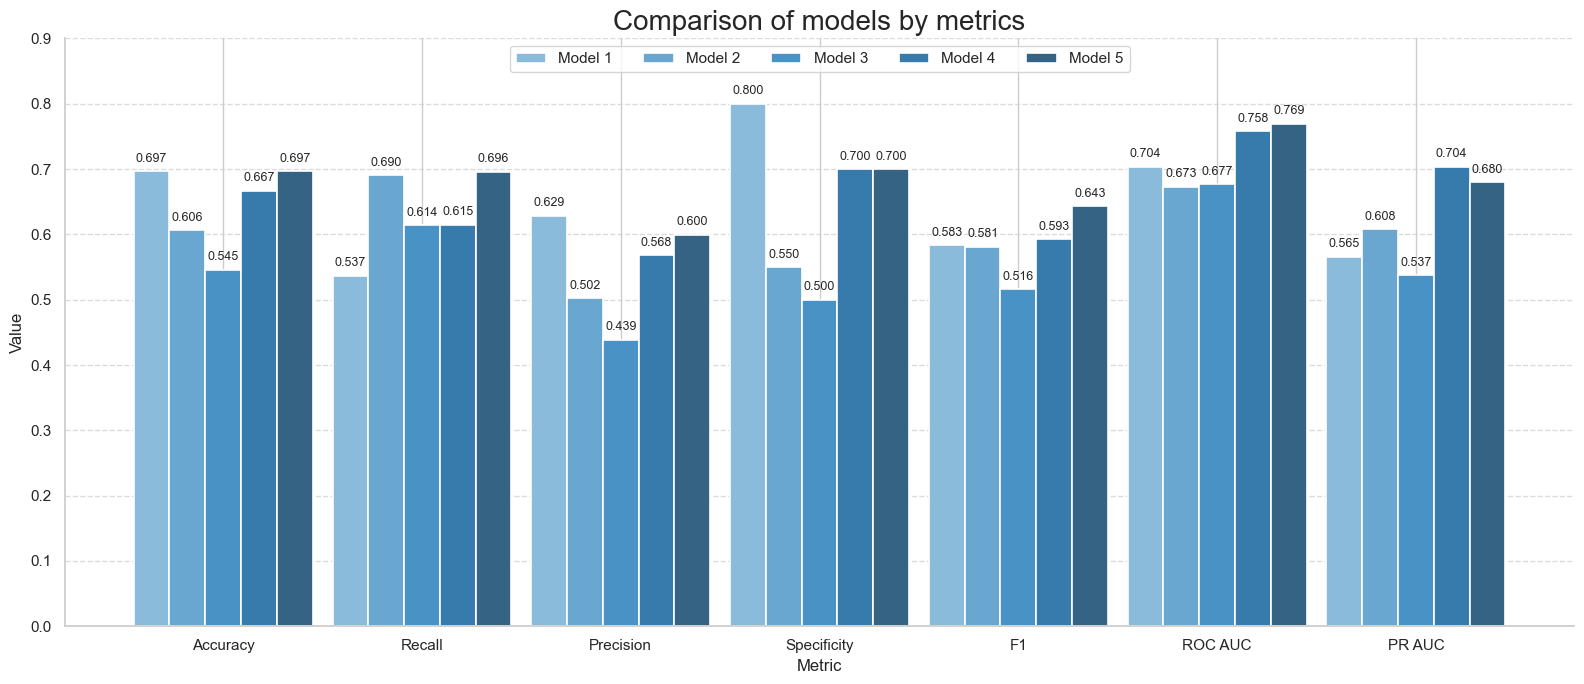

In [61]:
metrics = metrics_df.index.tolist()
models = metrics_df.columns.tolist()
data_matrix = metrics_df.values  # shape (n_metrics, n_models)

fig, ax = plt.subplots(figsize=(16, 7))
n_metrics = len(metrics)
n_models = len(models)
width = 0.18
x = np.arange(n_metrics)

for i, model in enumerate(models):
    offset = width * (i - (n_models-1)/2)
    bars = ax.bar(x + offset, data_matrix[:, i], width, label=model, linewidth=1.2)
    for rect in bars:
        h = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., h + 0.01, f'{h:.3f}', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Metric', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('Comparison of models by metrics', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 0.90)
ax.legend(loc='upper center', ncol=5)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
for spine in ['top','right']:
    ax.spines[spine].set_visible(False)
plt.tight_layout()
plt.savefig('./images/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
